# HydroTrend

* Link to this notebook: https://github.com/csdms/pymt/blob/master/notebooks/hydrotrend.ipynb
* Package installation command: `$ conda install notebook pymt_hydrotrend`
* Command to download a local copy:

  `$ curl -O https://raw.githubusercontent.com/csdms/pymt/master/notebooks/hydrotrend.ipynb`
  
HydroTrend is a 2D hydrological water balance and transport model that simulates water discharge and sediment load at a river outlet. You can read more about the model, find references or download the C source code at: https://csdms.colorado.edu/wiki/Model:HydroTrend.

This notebook has been created by Irina Overeem, September 18, 2019.


### River Sediment Supply Modeling

This notebook is meant to give you a better understanding of what HydroTrend is capable of. In this example we are using a theoretical river basin of ~1990 km<sup>2</sup>, with 1200m of relief and a river length of
~100 km. All parameters that are shown by default once the HydroTrend Model is loaded are based
on a present-day, temperate climate. Whereas these runs are not meant to be specific, we are
using parameters that are realistic for the [Waiapaoa River][map_of_waiapaoa] in New Zealand. The Waiapaoa River
is located on North Island and receives high rain and has erodible soils, so the river sediment
loads are exceptionally high. It has been called the *"dirtiest small river in the world"*.


A more detailed description of applying HydroTrend to the Waipaoa basin, New Zealand has been published in WRR: [hydrotrend_waipaoa_paper]. 


[map_of_waiapaoa]: https://www.google.com/maps/place/Waipaoa+River/@-38.5099042,177.7668002,71814m/data=!3m1!1e3!4m5!3m4!1s0x6d65def908624859:0x2a00ef6165e1dfa0!8m2!3d-38.5392405!4d177.8843782
[hydrotrend_presentation]: https://csdms.colorado.edu/wiki/File:SedimentSupplyModeling02_2013.ppt
[hydrotrend_waipaoa_paper]: http://dx.doi.org/10.1029/2006WR005570

### Run HydroTrend Simulations with pymt



Now we will be using the capability of the Python Modeling Tool, pymt. Pymt is a Python toolkit for running and coupling Earth surface models. 

https://csdms.colorado.edu/wiki/PyMT


In [77]:
# To start, import numpy and matplotlib.
import matplotlib.pyplot as plt
import numpy as np

In [78]:
# Then we import the package
import pymt.models

hydrotrend = pymt.models.Hydrotrend()

In [79]:
import pymt

pymt.__version__

'1.3.1'

## Learn about the Model Input
<br>
HydroTrend will now be activated in PyMT. You can find information on the model, the developer, the papers that describe the moel in more detail etc. 
Importantly you can scroll down a bit to the Parameters list, it shows what parameters the model uses to control the simulations. The list is alphabetical and uses precisely specified 'Standard Names'.
Note that every parameter has a 'default' value, so that when you do not list it in the configure command, you will run with these values.


In [80]:
# Get basic information about the HydroTrend model
# help(hydrotrend)

### Exercise 1: Explore the Hydrotrend base-case river simulation

For this case study, first we will create a subdirectory in which the basecase (BC) simulation will be implemented. 

Then we specify for how long we will run a simulation: for 100 years at daily time-step.
This means you run Hydrotrend for 36,500 days total. 
This is also the line of code where you would add other input parameters with their values.

In [81]:
# Set up Hydrotrend model by indicating the number of years to run
# config_file, config_folder = hydrotrend.setup("CoquilleRiver")

In [82]:
config_file = 'hydro_config.txt'

In [83]:
config_folder = '/Users/ryan/Documents/ESPIn/coastal2025/CoquilleRiver'


With the cat command you can print character by character one of the two input files that HydroTrend uses.
HYDRO0.HYPS: This first file specifies the River Basin Hysometry - the surface area per elevation zone. The hypsometry captures the geometric characteristics of the river basin, how high is the relief, how much uplands are there versus lowlands, where would the snow fall elevation line be etcetera. <br>
HYDRO.IN: This other file specifies the basin and climate input data. 

In [84]:
# cat  _hydrotrendBC/HYDRO0.HYPS

In [85]:
# cat _hydrotrendBC/HYDRO.IN

In [86]:
# In pymt one can always find out what output a model generates by using the .output_var_names method.
hydrotrend.output_var_names

('atmosphere_bottom_air__domain_mean_of_temperature',
 'channel_exit_water_sediment~suspended__mass_flow_rate',
 'channel_exit_water_flow__speed',
 'channel_entrance_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water__volume_flow_rate',
 'channel_exit_water_x-section__width',
 'channel_exit_water_x-section__depth',
 'channel_entrance_water__volume_flow_rate',
 'atmosphere_water__domain_mean_of_precipitation_leq-volume_flux',
 'channel_exit_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water_sediment~suspended__mass_concentration')

In [87]:
# Now we initialize the model with the configure file and in the configure folder
hydrotrend.initialize(config_file, config_folder)

  Read_Rainfall_Etc MESSAGE: Unable to open input file ./HYDRO.CLIMATE 
    Hydrotrend will generate it's own climate values based on
    line 12-23 of the input values in the input file.

  openfiles WARNING: Unable to open the earthquake data file ./HYDRO0.QUAKE 
    Hydrotrend will run without the earthquake routine  for epoch 0
 Calculate mean discharge, epoch: 1
 Calculate daily discharge, epoch: 1
 Calculate mean suspended sediment load, epoch: 1
 Calculate daily suspended sediment load, epoch: 1


In [88]:
# this line of code lists time parameters, when, how long and at what timestep will the model simulation work?
hydrotrend.start_time, hydrotrend.time, hydrotrend.end_time, hydrotrend.time_step, hydrotrend.time_units

(0.0, 0.0, 365000.0, 1.0, 'd')

In [89]:
# this code declares numpy arrays for several important parameters we want to save.
n_days = int(hydrotrend.end_time)
q = np.empty(n_days)  # river discharge at the outlet
qs = np.empty(n_days)  # sediment load at the outlet
cs = np.empty(
    n_days
)  # suspended sediment concentration for different grainsize classes at the outlet
qb = np.empty(n_days)  # bedload at the outlet

# here we have coded up the time loop using i as the index
# we update the model with one timestep at the time, untill we reach the end time
# for each time step we also get the values for the output parameters we wish to
for i in range(n_days):
    hydrotrend.update()
    q[i] = hydrotrend.get_value("channel_exit_water__volume_flow_rate")
    qs[i] = hydrotrend.get_value(
        "channel_exit_water_sediment~suspended__mass_flow_rate"
    )
    cs[i] = hydrotrend.get_value(
        "channel_exit_water_sediment~suspended__mass_concentration"
    )
    qb[i] = hydrotrend.get_value("channel_exit_water_sediment~bedload__mass_flow_rate")

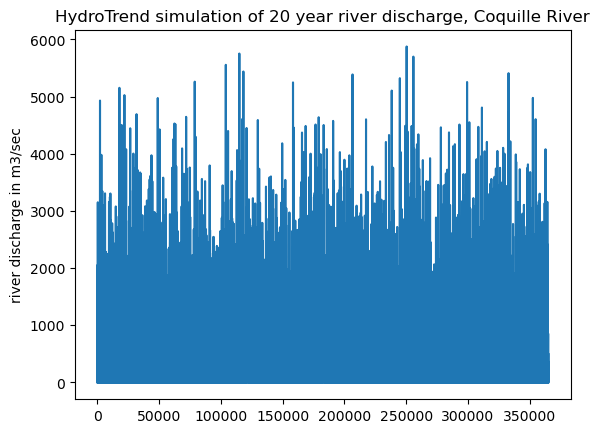

In [90]:
# We can plot the simulated output timeseries of Hydrotrend, for example the river discharge

plt.plot(q)
plt.title("HydroTrend simulation of 20 year river discharge, Coquille River")
plt.ylabel("river discharge in m3/sec")
plt.show()


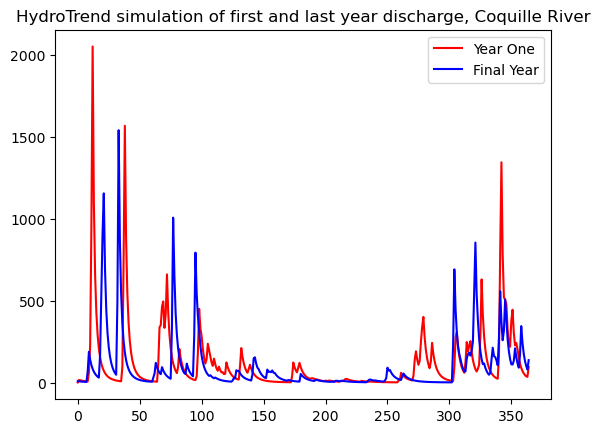

In [91]:
# Or you can plot a subset of the simulated daily timeseries using the index

# for example the first year
plt.plot(q[0:365], "r", label="Year One")
# compare with the last year
plt.plot(q[-366:-1], "b", label="Final Year")
plt.title("HydroTrend simulation of first and last year discharge, Coquille River")
plt.legend()
plt.show()

In [92]:
qb.mean()

7.0646085951834534

In [76]:
# Of course, it is important to calculate statistical properties of the simulated parameters

print(qb.mean())
hydrotrend.get_var_units("channel_exit_water_sediment~bedload__mass_flow_rate")

7.15399015337


/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_63776/3822306918.py:4: DeprecationWarning: Call to deprecated method get_var_units. (use var_units)
  hydrotrend.get_var_units("channel_exit_water_sediment~bedload__mass_flow_rate")


'kg / s'

 ## <font color = green> Assignment 1 </font> 

Calculate mean water discharge Q, mean suspended load Qs, mean sediment concentration Cs, and mean bedload Qb for this 100 year simulation of the river dynamics of the Waiapaoa River.
Note all values are reported as daily averages. What are the units?


In [17]:
# your code goes here

## <font color = green> Assignment 2 </font> 

Identify the highest flood event for this simulation. Is this the 100-year flood? Please list a definition of a 100 year flood, and discuss whether the modeled extreme event fits this definition. 
Plot the year of Q-data which includes the flood.


In [18]:
# here you can calculate the maximum river discharge.

In [19]:
# your code to determine which day and which year encompass the maximum discharge go here
# Hint: you will want to determine the ndex of htis day first, look into the numpy.argmax and numpy.argmin

# as a sanity check you can see whether the plot y-axis seems to go up to the maximum you had calculated in the previous step
# as a sanity check you can look in the plot of all the years to see whether the timing your code predicts is correct

In [20]:
# type your explanation about the 100 year flood here.

## <font color = green> Assignment 3 </font> 

Calculate the mean annual sediment load for this river system.

Then compare the annual load of the Waiapaoha river to the Mississippi River. <br>
To compare the mean annual load to other river systems you will need to calculate its sediment yield. 
Sediment Yield is defined as sediment load normalized for the river drainage area; 
so it can be reported in T/km2/yr.



In [21]:
# your code goes here
# you will have to sum all days of the individual years, to get the annual loads, then calculate the mean over the 100 years.
# one possible trick is to use the .reshape() method
# plot a graph of the 100 years timeseries of the total annual loads

In [22]:
# take the mean over the 100 years

In [23]:
# your evaluation of the sediment load of the Waiapaoha River and its comparison to the Mississippi River goes here.
# Hint: use the following paper to read about the Mississippi sediment load (Blum, M, Roberts, H.,  2009. Drowning of the Mississippi Delta due to insufficient sediment supply and global sea-level rise, Nature Geoscience).

### HydroTrend Exercise 2: How does a river system respond to climate change; two simple scenarios for the coming century.

Now we will look at changing climatic conditions in a small river basin. We'll change temperature and precipitation regimes and compare discharge and sediment load characteristics to the original basecase. And we will look at the are potential implications of changes in the peak events.

Modify the mean annual temperature T, the mean annual precipitation P. You can specify trends over time, by modifying the parameter ‘change in mean annual temperature’ or ‘change in mean annual precipitation’. HydroTrend runs at daily timestep, and thus can deal with seasonal variations in temperature and precipitation for a basin. The model ingests monthly mean input values for these two climate parameters and their monthly standard deviations, ideally the values would be derived from analysis of a longterm record of daily climate data. You can adapt seasonal trends by using the monthly values.

## <font color = green> Assignment 4 </font> 
What happens to river discharge, suspended load and bedload if the mean annual temperature in this specific river basin increases by 4 °C over the next 50 years? In this assignment we set up a new simulation for a warming climate.

In [24]:
# Set up a new run of the Hydrotrend model
# Create a new config file a different folder for input and output files, indicating the number of years to run, and specify the change in mean annual temparture parameter
hydrotrendHT = pymt.models.Hydrotrend()
config_file, config_folder = hydrotrendHT.setup(
    "_hydrotrendhighT", run_duration=50, change_in_mean_annual_temperature=0.08
)

In [25]:
# intialize the new simulation
hydrotrendHT.initialize(config_file, config_folder)

  Read_Rainfall_Etc MESSAGE: Unable to open input file ./HYDRO.CLIMATE 
    Hydrotrend will generate it's own climate values based on
    line 12-23 of the input values in the input file.

  openfiles WARNING: Unable to open the earthquake data file ./HYDRO0.QUAKE 
    Hydrotrend will run without the earthquake routine  for epoch 0
 Calculate mean discharge, epoch: 1
 Calculate daily discharge, epoch: 1
 Calculate mean suspended sediment load, epoch: 1
 Calculate daily suspended sediment load, epoch: 1


In [26]:
# the code for the timeloop goes here
# I use the abbrevation HT for 'High Temperature' scenario
n_days = int(hydrotrendHT.end_time)
q_HT = np.empty(n_days)  # river discharge at the outlet
qs_HT = np.empty(n_days)  # sediment load at the outlet
cs_HT = np.empty(
    n_days
)  # suspended sediment concentration for different grainsize classes at the outlet
qb_HT = np.empty(n_days)  # bedload at the outlet
for i in range(n_days):
    hydrotrendHT.update()
    q_HT[i] = hydrotrendHT.get_value("channel_exit_water__volume_flow_rate")
    qs_HT[i] = hydrotrendHT.get_value(
        "channel_exit_water_sediment~suspended__mass_flow_rate"
    )
    cs_HT[i] = hydrotrendHT.get_value(
        "channel_exit_water_sediment~suspended__mass_concentration"
    )
    qb_HT[i] = hydrotrendHT.get_value(
        "channel_exit_water_sediment~bedload__mass_flow_rate"
    )

In [27]:
# your code that prints out the mean river discharge, the mean sediment load and the mean bedload goes here


# print out these same parameters for the basecase for comparison

## <font color = green> Assignment 5 </font> 

So what is the effect of a warming basin temperature? 
How much increase or decrease of river discharge do you see after 50 years? <br>
How is the mean suspended load affected? <br>
How does the mean bedload change? <br>
What happens to the peak event; look at the maximum sediment load event of the last 5 years of the simulation?

In [28]:
# type your answers here

## <font color = green> Assignment 6 </font>
What happens to river discharge, suspended load and bedload if the mean annual precipitation would increase by 50% in this specific river basin over the next 50 years? Create a new simulation folder, High Precipitation, HP, and set up a run with a trend in future precipitation. 

In [29]:
# Set up a new run of the Hydrotrend model
# Create a new config file indicating the number of years to run, and specify the change in mean annual precipitation parameter

In [30]:
# initialize the new simulation

In [31]:
# your code for the timeloop goes here

In [32]:
# your code that prints out the mean river discharge, the mean sediment load and the mean bedload goes here

## <font color = green> Assignment 7 </font>

In addition, climate model predictions indicate that perhaps precipitation intensity and variability could increase. How would you possibly model this? Discuss how you would modify your input settings for precipitation.



In [33]:
# type your answer here

### Exercise 3: How do humans affect river sediment loads?

Here we will look at the effect of human in a river basin. Humans can accelerate erosion
processes, or reduce the sediment loads traveling through a river system. Both concepts can
be simulated, first run 3 simulations systematically increasing the anthropogenic factor (0.5-8.0 is the range).

## <font color = green> Assignment 8 </font>
Describe in your own words the meaning of the human-induced erosion factor, (Eh). This factor is parametrized as the  “Antropogenic” factor in HydroTrend. Read more about this in: Syvitski & Milliman, 2007, Geology, Geography, and Humans Battle for Dominance over the Delivery of Fluvial Sediment to the Coastal Ocean. 2007, 115, p. 1–19. 

In [34]:
# your explanation goes here, can you list two reasons why this factor would be unsuitable or it would fall short?

## <font color = green> Bonus Assignment 9 </font>
Model a scenario of a drinking water supply reservoir to be planned in the coastal area of the basin. The reservoir would have 800 km 2of contributing drainage area and be 3 km long, 200m wide and 100m deep. Set up a simulation with these parameters.

In [35]:
# Set up a new 50 year of the Hydrotrend model
# Create a new directory, and a config file indicating the number of years to run, and specify different reservoir parameters

In [36]:
# initialize the new simulation

In [37]:
# your code for the timeloop and update loop goes here

In [38]:
# plot a bar graph comparing Q mean, Qs mean, Qmax, Qs Max, Qb mean and Qbmax for the basecase run and the reservoir run

In [39]:
# Describe how such a reservoir affects the water and sediment load at the coast (i.e. downstream of the reservoir)?

## <font color = green> Bonus Assignment 10 </font>
Set up a simulation for a different river basin. 
This means you would need to change the HYDRO0.HYPS file and change some climatic parameters. 
There are several hypsometric files packaged with HydroTrend, you can use one of those, but are welcome to do something different!

In [40]:
# write a short motivation and description of your scenario

In [41]:
# make a 2 panel plot using the subplot functionality of matplotlib
# One panel would show the hypsometry of the Waiapohoa and the other panel the hypsometry of your selected river basin

In [42]:
# Set up a new 50 year of the Hydrotrend model
# Create a new directory for this different basin

In [43]:
# initialize the new simulation

In [44]:
# your code for the timeloop and update loop goes here

In [45]:
# plot a line graph comparing Q mean, Qs mean, for the basecase run and the new river basin run

## <font color = green>  ALL DONE! </font>